In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
from dali.data import Lines, DiscoverFiles, BatchBenefactor, DataGenerator
from dali.data.batch import LMBatch

from dali.utils import Vocab, median_smoothing, throttled, pickle_globals, unpickle_globals
from dali import beam_search

%matplotlib inline

In [3]:
D.config.default_device = 'gpu'

In [4]:
# first 10k words from glove
GLOVE_VOCAB = '/home/sidor/projects/Dali/data/glove/vocab10k.txt'
# Bookcorpus - pretokenized
BOOKCORPUS  = '/home/sidor/datasets/bookcorpus/'

# network sizes
INPUT_SIZE = 256
HIDDENS = [1024, 1024]
SOFTMAX_INPUT = 256
# dataset / training parameters
MINIBATCH = 512
SENTENCES_UNTIL_MINIBATCH = 1000 * MINIBATCH
SENTENCE_LENGTH=(2, 12)

# Data loading

In [5]:
glove_vocab = Vocab()
with open(GLOVE_VOCAB, "rt") as f:
    glove_vocab.add(word for word in f.read().split('\n') if word != '')
glove_vocab.add(LMBatch.START_TOKEN)
print("I have %d words in my vocabulary, how fun!" % (len(glove_vocab),))

I have 10003 words in my vocabulary, how fun!


In [6]:
def extract_bookcorpus(path, vocab, minibatch_size, sentences_until_minibatch=None, sentence_length_bounds=(2, 20)):
    sentences_until_minibatch = sentences_until_minibatch or 10000 * minibatch_size
    files   = DiscoverFiles(path, ".txt")
    mapper = Lines()          \
              .lower()        \
              .split_spaces() \
              .bound_length(*sentence_length_bounds)
    reducer = BatchBenefactor(minibatch_size,
                              LMBatch.given_vocab(glove_vocab, store_originals=True),
                              sentences_until_minibatch)
    return DataGenerator(files=files, mapper=mapper, reducer=reducer)


# Model definition 

In [7]:
class LanguageModel(object):
    def __init__(self, input_size, hiddens, vocab_size, softmax_input_size=None, dtype=np.float32):
        self.input_size = input_size
        self.hiddens    = hiddens
        self.vocab_size = vocab_size
        self.softmax_input_size = softmax_input_size
        self.dtype = dtype
        
        self.encoder = D.random.uniform(-0.05, 0.05, (vocab_size, input_size), dtype=dtype)
        self.lstm    = D.StackedLSTM(input_size, hiddens, dtype=dtype)
        if self.softmax_input_size is not None:
            self.predecoder = D.Layer(self.hiddens[-1], self.softmax_input_size)
            self.decoder = D.Layer(self.softmax_input_size, vocab_size, dtype=dtype)
        else:    
            self.decoder = D.Layer(hiddens[-1], vocab_size, dtype=dtype)
    
    def decode_state(self, state):
        if self.softmax_input_size is not None:
            decoder_input = self.predecoder.activate(state[-1].hidden)
        else:
            decoder_input = state[-1].hidden
        return self.decoder.activate(decoder_input)
        
    def error(self, batch):
        error = D.Mat(1,1)
        state = self.lstm.initial_states()
        for ts in range(batch.timesteps):
            inputs  = batch.inputs(ts)
            targets = batch.targets(ts)
            if inputs:
                encoded = self.encoder[batch.inputs(ts)]
            else:
                encoded = Mat(1, self.input_size)
            state = self.lstm.activate(encoded, state)
            if targets:
                decoded = self.decode_state(state)
                error = error + D.MatOps.softmax_cross_entropy(decoded, targets).sum()
        return error
    
    def sample(self, priming, temperature=1.0, **kwargs):
        with D.NoBackprop():
            state = self.lstm.initial_states()
            for word_idx in priming:
                encoded = self.encoder[word_idx]
                state = self.lstm.activate(encoded, state)
            def candidate_scores(state):
                decoded = self.decode_state(state)
                return D.MatOps.softmax(decoded, temperature=temperature).log()
            def make_choice(state, candidate_idx):
                encoded = self.encoder[candidate_idx]
                return self.lstm.activate(encoded, state)

            return beam_search(state,
                               candidate_scores,
                               make_choice,
                               **kwargs)
    
    def parameters(self):
        ret = [self.encoder] + self.lstm.parameters() + self.decoder.parameters()
        if self.softmax_input_size is not None:
            ret.extend(self.predecoder.parameters())
        return ret

In [8]:
def show_reconstructions(model, words, temperature=1.0):
    for solution, score, _ in model.sample(glove_vocab.encode([LMBatch.START_TOKEN] + words), 
                                           eos_symbol=glove_vocab.eos,
                                           max_sequence_length=20,
                                           blacklist=[glove_vocab.unk],
                                           temperature=temperature):
        score = math.exp(score.w[0])
        priming = ' '.join(words)
        solution = ' '.join(glove_vocab.decode(solution, False))
        print('%f => [%s] %s' % (score, priming, solution))

# Create new experiment 

In [9]:
model  = LanguageModel(INPUT_SIZE, HIDDENS, len(glove_vocab), softmax_input_size=SOFTMAX_INPUT)

In [10]:
params = model.parameters()
solver = D.SGD(params)
solver.step_size = 0.7

In [11]:
data = []
epochs_done = 0

In [12]:
error_evolution = []

# (Optional) continue running previous attempt 

In [9]:
unpickle_globals("/home/sidor/tmp/lm_experiment")
params = model.parameters()

# Training

In [13]:
total_error, num_words = 0.0, 0
batch_time, num_batches = 0.0, 0

@throttled(5)
def report(example):
    if num_batches == 0 or num_words == 0 or abs(batch_time) < 1e-6:
        return
    clear_output()
    print('Error:             ', total_error / num_words)
    print('Time per batch:    ', batch_time  / num_batches)
    print('Words per second:  ', num_words   / batch_time )
    print('Batches processed: ', num_batches)
    show_reconstructions(model, example)
    sys.stdout.flush()
    

batch_end_time, batch_start_time = None, None

while True:
    for batch in data:    
        batch_start_time = time.time()
        error = model.error(batch)

        error.grad()
        D.Graph.backward()
        solver.step(params)
        batch_end_time = time.time()

        error_evolution.append(error.w[0,0] / sum(batch.sentence_lengths))
        if len(error_evolution) > 5000:
            error_evolution = error_evolution[::2]

        total_error += error.w[0, 0]
        num_words   += sum(batch.sentence_lengths)

        if batch_end_time is not None and batch_start_time is not None:
            batch_time += batch_end_time - batch_start_time
        num_batches    += 1

        example = batch.sentences[0]
        example_len = random.randint(1, len(example))

        report(example[:example_len])
    
    epochs_done += 1
    data = extract_bookcorpus(BOOKCORPUS, glove_vocab, MINIBATCH, 
                          SENTENCES_UNTIL_MINIBATCH, sentence_length_bounds=SENTENCE_LENGTH)

Error:              13.7454066541
Time per batch:     0.40337294528358864
Words per second:   10880.201557104729
Batches processed:  95
1.000000 => ['' this one has some potential , '' he] himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself
0.000000 => ['' this one has some potential , '' he] himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself **START**
0.000000 => ['' this one has some potential , '' he] himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself quinn
0.000000 => ['' this one has some potential , '' he] himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself himself resistant
0.000000 =

KeyboardInterrupt: 

In [24]:
pickle_globals("/home/sidor/tmp/lm_experiment", ["model", "solver", "data", "error_evolution"])

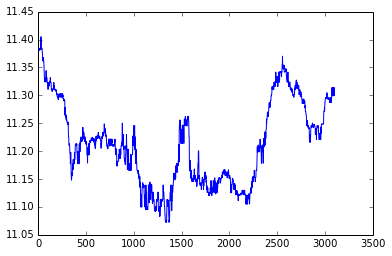

In [14]:
plt.plot(median_smoothing(error_evolution, window=len(error_evolution) // 10 ) )

In [23]:
show_reconstructions(model, "Give".split(' '))

0.000158 => [Give] was , . **EOS**
0.000154 => [Give] , , . **EOS**
0.000139 => [Give] 's , . **EOS**
0.000012 => [Give] was , , . **EOS**
0.000012 => [Give] , , , . **EOS**


1000

In [15]:
epochs_done

3